Data Source: https://www.kaggle.com/datasets/hugomathien/soccer/data

SQL Tables:<br>
Country <br>
League<br>
Match<br>
Player<br>
Player_Attributes<br>
Team<br>
Team_Attributes

SQL code: Extracted and engineered team-level and player-level match features by writing a comprehensive SQL query over a soccer match database. For each match, calculated:

* Individual player attributes such as age, overall rating, and position-specific skill scores by joining match data with the latest available player records.

* Team-level statistics including average height, average skill ratings (e.g., attacking, defensive, physical, field, shooting, and goalkeeping), and team tactical attributes.

* Used subqueries to align player and team attributes with match timing, ensuring accurate historical context.

* Engineered features for 22 players per match and aggregated them into meaningful summary statistics used for downstream machine learning models (e.g., match outcome prediction).

This code file involved extensive data cleaning and feature engineering on a football match dataset. Missing values were handled by dropping columns with over 30% missingness and imputing the rest using median values. Feature engineering included creating team-level averages for player age and overall ratings, and constructing a binary target variable indicating whether the home team won. Irrelevant or redundant features—such as individual player IDs, ages, and ratings—were dropped to reduce dimensionality. Decision tree models were then trained and visualized to interpret model behavior.

In [2]:
# Importing necessary libraries for data analysis
import pandas as pd
import numpy as np

/Users/veeksha_work/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/veeksha_work/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [3]:
# reading the csv file
footballdf = pd.read_csv('EUfootball2.csv')
footballdf.shape

(5000, 99)

In [4]:
# First look at features
footballdf.head(2)

,match_id,country_id,home_team_api_id,away_team_api_id,mdatetime,pdatetime,home_player_1,home_player1_age,home_player1_overall_rating,home_player_2,...,home_team_buildUpPlayPositioningClass,home_team_defenceDefenderLineClass,home_team_chanceCreationPositioningClass,away_team_buildUpskills,away_team_chanceCreationSkills,away_team_defenceSkills,away_team_buildUpPlayPositioningClass,away_team_defenceDefenderLineClass,away_team_chanceCreationPositioningClass,winner
0,1992225,24558,9931,9956,2016-05-25,2015-10-02,42113,35,64,458806,...,Organised,Cover,Organised,54.67,50.67,42.00,Organised,Cover,Organised,9956
1,1992226,24558,7896,10190,2016-05-25,2016-03-10,330458,22,61,282287,...,NaN,NaN,NaN,48.67,38.33,42.67,Organised,Cover,Organised,7896


### Cleaning Dataset

In [5]:
# Checking for missing values - threshold is 30%. 
missing_summary = (
    pd.DataFrame({
        'Missing': footballdf.isnull().sum(),
        'Percent': footballdf.isnull().mean() * 100,
        'Total': len(footballdf)
    })
    .query('Missing > 0')  # Only show columns with missing values
    .sort_values('Missing', ascending=False)
)

missing_summary.head(3)

,Missing,Percent,Total
away_team_buildUpskills,199,3.98,5000
home_team_buildUpskills,195,3.90,5000
home_team_defenceSkills,93,1.86,5000


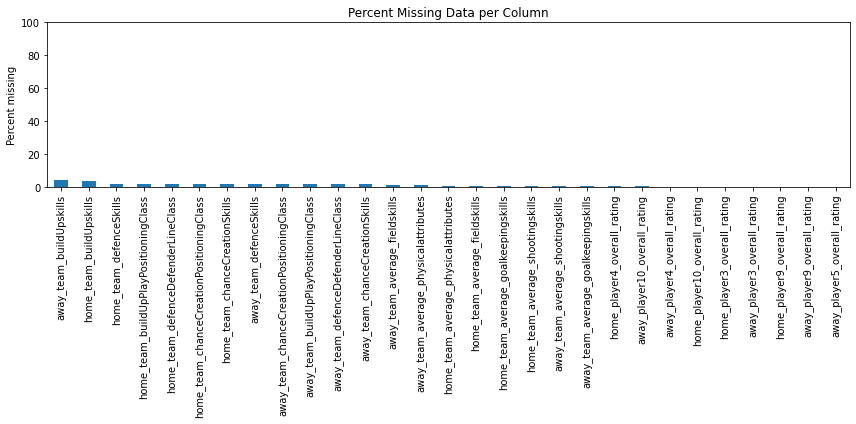

In [6]:
import matplotlib.pyplot as plt

# Bar plot of percent missing per column (only columns with missing values)
missing_summary['Percent'].plot.bar(figsize=(12, 6))
plt.ylabel('Percent missing')
plt.title('Percent Missing Data per Column')
plt.ylim(0, 100)  # Set y-axis from 0 to 100%
plt.tight_layout()
plt.show()

In [7]:
# Extract the first 12 column names from the index of missing_summary
cols_to_drop = missing_summary.index[:12].tolist()

# Drop these columns from footballdf
footballdf = footballdf.drop(columns=cols_to_drop)

# Check new shape or columns
print("New shape:", footballdf.shape)

New shape: (5000, 87)


In [8]:
# Creating a list of features that need values to be imputed
cols_to_impute = missing_summary.index[12:].tolist()

In [9]:
# Imputing the median value of the feature in missing data points
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
footballdf[cols_to_impute] = imputer.fit_transform(footballdf[cols_to_impute])

# Checking for any more missing values - there should be none
missing_summary2 = (
    pd.DataFrame({
        'Missing': footballdf.isnull().sum(),
        'Percent': footballdf.isnull().mean() * 100,
        'Total': len(footballdf)
    })
    .query('Missing > 0')  # Only show columns with missing values
    .sort_values('Missing', ascending=False)
)

missing_summary2

,Missing,Percent,Total


### Feature Engineering

In [10]:
# Building a binary target variable
footballdf['home_team_won'] = (footballdf['winner'] == footballdf['home_team_api_id']).astype(int)
footballdf.drop('winner', axis = 1, inplace = True)

In [11]:
# Dropping ID features
dtdf = footballdf.drop(['match_id', 'home_team_api_id', 'away_team_api_id', 'mdatetime', 'pdatetime'], axis = 1)
dtdf.shape

(5000, 82)

In [12]:
# Averaging the age of 11 players on home team
home_age_cols = [f'home_player{i}_age' for i in range(1, 12)]
footballdf['home_avg_age'] = footballdf[home_age_cols].mean(axis=1)

# Averaging overall_rating of 11 players on home teams
home_rating_cols = [f'home_player{i}_overall_rating' for i in range(1, 12)]
footballdf['home_avg_overall_rating'] = footballdf[home_rating_cols].mean(axis=1)

In [13]:
# Averaging the age of 11 players on away teams
away_age_cols = [f'away_player{i}_age' for i in range(1, 12)]
footballdf['away_avg_age'] = footballdf[away_age_cols].mean(axis=1)

# Averaging overall_rating of 11 players on away teams
away_rating_cols = [f'away_player{i}_overall_rating' for i in range(1, 12)]
footballdf['away_avg_overall_rating'] = footballdf[away_rating_cols].mean(axis=1)

In [14]:
# List of columns to drop, including individual player id, age, and overall ratings
cols_to_drop = [
    'home_player_1', 'home_player1_age', 'home_player1_overall_rating',
    'home_player_2', 'home_player2_age', 'home_player2_overall_rating',
    'home_player_3', 'home_player3_age', 'home_player3_overall_rating',
    'home_player_4', 'home_player4_age', 'home_player4_overall_rating',
    'home_player_5', 'home_player5_age', 'home_player5_overall_rating',
    'home_player_6', 'home_player6_age', 'home_player6_overall_rating',
    'home_player_7', 'home_player7_age', 'home_player7_overall_rating',
    'home_player_8', 'home_player8_age', 'home_player8_overall_rating',
    'home_player_9', 'home_player9_age', 'home_player9_overall_rating',
    'home_player_10', 'home_player10_age', 'home_player10_overall_rating',
    'home_player_11', 'home_player11_age', 'home_player11_overall_rating',
    'away_player_1', 'away_player1_age', 'away_player1_overall_rating',
    'away_player_2', 'away_player2_age', 'away_player2_overall_rating',
    'away_player_3', 'away_player3_age', 'away_player3_overall_rating',
    'away_player_4', 'away_player4_age', 'away_player4_overall_rating',
    'away_player_5', 'away_player5_age', 'away_player5_overall_rating',
    'away_player_6', 'away_player6_age', 'away_player6_overall_rating',
    'away_player_7', 'away_player7_age', 'away_player7_overall_rating',
    'away_player_8', 'away_player8_age', 'away_player8_overall_rating',
    'away_player_9', 'away_player9_age', 'away_player9_overall_rating',
    'away_player_10', 'away_player10_age', 'away_player10_overall_rating',
    'away_player_11', 'away_player11_age', 'away_player11_overall_rating'
]

# Drop specified columns from the DataFrame
dtdf2 = dtdf.drop(columns=cols_to_drop)

dtdf2.head()

,country_id,home_team_average_height,home_team_average_attacking_work_rate,home_team_average_defensive_work_rate,home_team_average_fieldskills,home_team_average_shootingskills,home_team_average_physicalattributes,home_team_average_goalkeepingskills,away_team_average_height,away_team_average_attacking_work_rate,away_team_average_defensive_work_rate,away_team_average_fieldskills,away_team_average_shootingskills,away_team_average_physicalattributes,away_team_average_goalkeepingskills,home_team_won
0,24558,180.34,21,20,52.99,48.06,65.62,15.24,182.19,20,19,51.71,45.46,63.03,15.47,0
1,24558,178.72,21,18,45.16,35.30,60.14,15.60,180.80,23,20,50.31,43.76,62.43,15.36,1
2,24558,180.34,21,20,53.81,47.88,63.27,14.25,180.80,22,19,55.43,53.85,66.25,15.15,0
3,24558,181.73,20,21,47.73,43.67,61.27,14.58,182.42,20,19,54.56,51.33,65.58,15.07,0
4,24558,181.73,20,20,51.97,43.94,62.75,14.95,182.65,20,18,49.24,42.88,59.35,13.65,1


In [15]:
dtdf2.to_csv('Europeanfootball.csv', index=False)

### Model Building

In [99]:
# Importing ml libraries for decision tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score

In [100]:
# Prepare features (X) and target (y)
X = dtdf2.drop('home_team_won', axis=1)
y = dtdf2['home_team_won']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Manually coded decision tree

In [101]:
# Function to compute the Gini impurity
def gini_impurity(arr):
    classes, counts = np.unique(arr, return_counts=True)
    probabilities = counts / counts.sum()
    gi = 1 - np.sum(probabilities ** 2)
    return gi

In [102]:
gini_impurity(y_train)

0.4940048750000001

In [103]:
# Function to compute the weighted average Gini impurity
def weighted_avg_gi(y_left, y_right, n):
    gini_left = gini_impurity(y_left)
    gini_right = gini_impurity(y_right)

    n_left = len(y_left)
    n_right = len(y_right)
    weighted_gini = (n_left / n) * gini_left + (n_right / n) * gini_right
    
    return weighted_gini

In [104]:
# Find the best split point for a continuous feature column X_col with respect to the label vector y, 
# using the Gini impurity criterion.

def best_gini_split(X_col, y):
    # Sort feature values and corresponding labels
    sorted_idx = np.argsort(X_col)
    X_sorted = X_col[sorted_idx]
    y_sorted = y[sorted_idx]
    
    # Possible split points are midpoints between unique values
    unique_vals = np.unique(X_sorted)
    if len(unique_vals) == 1:
        return None, None  # No split possible

    thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2

    best_gini = float('inf')
    best_threshold = None

    for threshold in thresholds:
        left_mask = X_sorted <= threshold
        right_mask = X_sorted > threshold

        y_left = y_sorted[left_mask]
        y_right = y_sorted[right_mask]

        if len(y_left) == 0 or len(y_right) == 0:
            continue  # Skip invalid splits

        gini_left = gini_impurity(y_left)
        gini_right = gini_impurity(y_right)

        # Weighted average Gini impurity
        n = len(y_sorted)
        weighted_gini = weighted_avg_gi(y_left, y_right, n)

        if weighted_gini < best_gini:
            best_gini = weighted_gini
            best_threshold = threshold

    return best_threshold, best_gini

In [105]:
def build_decision_tree(X, y, max_depth=None, min_samples_leaf=1, depth=0):
    n_samples, n_features = X.shape
    
    # compute current node's Gini impurity and majority class
    current_gini = gini_impurity(y)
    majority_class = np.bincount(y).argmax()
    
    # Stopping criteria
    if (max_depth is not None and depth >= max_depth) or \
       (n_samples <= min_samples_leaf) or (current_gini == 0):
        return {'type': 'leaf', 'class': majority_class}
    
    best_feature = None
    best_threshold = None
    best_gini = current_gini  # use current impurity
    
    # feature selection loop
    for feature in range(n_features):
        X_col = X[:, feature]
        threshold, split_gini = best_gini_split(X_col, y)
        
        # Only consider splits that improve impurity
        if threshold is not None and split_gini < best_gini:
            best_gini = split_gini
            best_feature = feature
            best_threshold = threshold
    
    # No split improves purity; return leaf
    if best_gini >= current_gini:
        return {'type': 'leaf', 'class': majority_class}
    
    # Split data into child nodes
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask
    
    # Recursively build subtrees
    left_subtree = build_decision_tree(X[left_mask], y[left_mask], max_depth, min_samples_leaf, depth + 1)
    right_subtree = build_decision_tree(X[right_mask], y[right_mask], max_depth, min_samples_leaf, depth + 1)
    
    return {
        'type': 'node',
        'feature': best_feature,
        'threshold': best_threshold,
        'left': left_subtree,
        'right': right_subtree
    }

In [106]:
# Convert pd training inputs into arrays
X1 = np.array(X_train)
y1 = np.array(y_train)
dtree = build_decision_tree(X1, y1, max_depth=4)

#### Decision tree building using sklearn

In [107]:
# Initialize and train the decision tree
clf = DecisionTreeClassifier(max_depth = 4,random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

### Predictions

#### Manually coded decision tree predictions

In [108]:
# Predict the class for a single sample by traversing the tree.
def predict_single(sample, node):
    while node['type'] != 'leaf':
        feature = node['feature']
        threshold = node['threshold']
        if sample[feature] <= threshold:
            node = node['left']
        else:
            node = node['right']
    return node['class']

# Predict class labels for all samples in X using the decision tree.
def treepredict(X, tree):
    return np.array([predict_single(sample, tree) for sample in X])


In [109]:
# Convert pd testing inputs into arrays
X2 = np.array(X_test)
manual_ypred = treepredict(X2,dtree)

#### Decision tree predictions using sklearn

In [110]:
# Predict class of X_Test values
y_pred = clf.predict(X_test)

### Model Evaluations

#### Evaluating manually coded decision tree predictions

In [111]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, manual_ypred)
print(f"Accuracy: {accuracy:.2f}")

print(confusion_matrix(y_test, manual_ypred))
print(classification_report(y_test, manual_ypred))

Accuracy: 0.65
[[476  82]
 [270 172]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       558
           1       0.68      0.39      0.49       442

    accuracy                           0.65      1000
   macro avg       0.66      0.62      0.61      1000
weighted avg       0.66      0.65      0.63      1000



#### Evaluating sklearn decision tree predictions

In [112]:
accuracy2 = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy2:.2f}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.65
[[476  82]
 [270 172]]
              precision    recall  f1-score   support

           0       0.64      0.85      0.73       558
           1       0.68      0.39      0.49       442

    accuracy                           0.65      1000
   macro avg       0.66      0.62      0.61      1000
weighted avg       0.66      0.65      0.63      1000



### Tree Structure Visualizations

#### Visualizing manually coded decision tree

In [113]:
# Viewing the structure of the manually built tree
dtree

{'type': 'node',
 'feature': 4,
 'threshold': 60.935,
 'left': {'type': 'node',
  'feature': 13,
  'threshold': 66.655,
  'left': {'type': 'node',
   'feature': 6,
   'threshold': 64.215,
   'left': {'type': 'node',
    'feature': 11,
    'threshold': 50.325,
    'left': {'type': 'leaf', 'class': 0},
    'right': {'type': 'leaf', 'class': 0}},
   'right': {'type': 'node',
    'feature': 11,
    'threshold': 53.275000000000006,
    'left': {'type': 'leaf', 'class': 1},
    'right': {'type': 'leaf', 'class': 0}}},
  'right': {'type': 'node',
   'feature': 5,
   'threshold': 52.345,
   'left': {'type': 'node',
    'feature': 4,
    'threshold': 55.83,
    'left': {'type': 'leaf', 'class': 0},
    'right': {'type': 'leaf', 'class': 0}},
   'right': {'type': 'node',
    'feature': 11,
    'threshold': 61.985,
    'left': {'type': 'leaf', 'class': 0},
    'right': {'type': 'leaf', 'class': 0}}}},
 'right': {'type': 'node',
  'feature': 11,
  'threshold': 61.870000000000005,
  'left': {'type'

In [114]:
# Visualizing tree
from graphviz import Source

def get_fillcolor(is_leaf, predicted_class):
    if not is_leaf:
        return "#fcf0b8"  # white for split nodes
    return "#f0c7c6" if predicted_class == 0 else "#90c8f0"  # red or blue-ish for leaves

def dict_to_dot(tree, dot_lines, node_counter, feature_names, class_names, parent=None, edge_label=''):
    node_id = node_counter[0]
    node_counter[0] += 1

    if tree['type'] == 'leaf':
        class_name = class_names[tree['class']]
        label = f'class = {class_name}'
        fillcolor = get_fillcolor(True, tree['class'])
    else:
        feature_label = feature_names[tree["feature"]]
        label = f'{feature_label} ≤ {tree["threshold"]:.2f}'
        fillcolor = get_fillcolor(False, None)

    dot_lines.append(
        f'  node{node_id} [label="{label}", style=filled, fillcolor="{fillcolor}", shape=box, fontname="helvetica", fontsize=12, penwidth=1.5, rounded=true];'
    )

    if parent is not None:
        dot_lines.append(f'  node{parent} -> node{node_id} [label="{edge_label}"];')

    if tree['type'] != 'leaf':
        dict_to_dot(tree['left'], dot_lines, node_counter, feature_names, class_names, parent=node_id, edge_label='True')
        dict_to_dot(tree['right'], dot_lines, node_counter, feature_names, class_names, parent=node_id, edge_label='False')

def visualize_tree(tree_dict, feature_names, class_names=['0', '1']):
    dot_lines = [
        'digraph Tree {',
        '  node [shape=box, fontname="helvetica"];'
    ]
    node_counter = [0]
    dict_to_dot(tree_dict, dot_lines, node_counter, feature_names, class_names)
    dot_lines.append('}')
    dot_string = '\n'.join(dot_lines)
    return Source(dot_string)


In [118]:
class_names = ['Lost', 'Won']

tree_viz = visualize_tree(dtree, fn, class_names)
tree_viz.view()

'Source.gv.pdf'

#### Visualizing sklearn decision tree

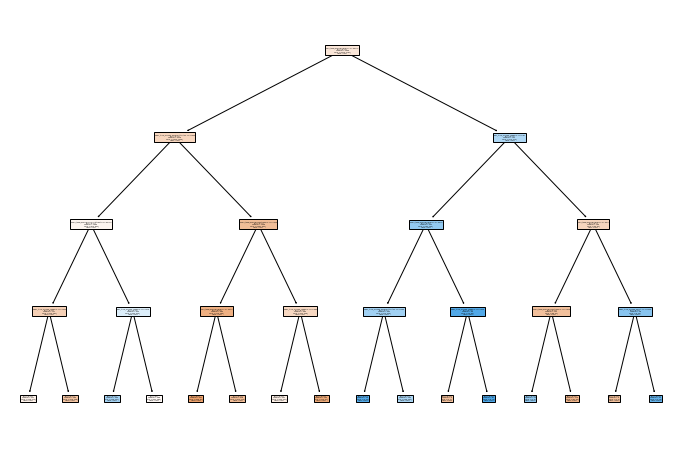

In [116]:
# Plotting the SKLEARN tree
from sklearn.tree import plot_tree
# Get the feature names from your DataFrame
fn = X.columns.tolist()

plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=fn, class_names=['Lost', 'Won'])
plt.show()

In [117]:
# Print the tree structure with feature names
tree_rules = export_text(clf, feature_names=fn)
print(tree_rules)

|--- home_team_average_fieldskills <= 60.93
|   |--- away_team_average_physicalattributes <= 66.66
|   |   |--- home_team_average_physicalattributes <= 64.22
|   |   |   |--- away_team_average_fieldskills <= 50.33
|   |   |   |   |--- class: 0
|   |   |   |--- away_team_average_fieldskills >  50.33
|   |   |   |   |--- class: 0
|   |   |--- home_team_average_physicalattributes >  64.22
|   |   |   |--- away_team_average_fieldskills <= 53.27
|   |   |   |   |--- class: 1
|   |   |   |--- away_team_average_fieldskills >  53.27
|   |   |   |   |--- class: 0
|   |--- away_team_average_physicalattributes >  66.66
|   |   |--- home_team_average_shootingskills <= 52.35
|   |   |   |--- home_team_average_fieldskills <= 55.83
|   |   |   |   |--- class: 0
|   |   |   |--- home_team_average_fieldskills >  55.83
|   |   |   |   |--- class: 0
|   |   |--- home_team_average_shootingskills >  52.35
|   |   |   |--- away_team_average_fieldskills <= 61.99
|   |   |   |   |--- class: 0
|   |   |   |---

In [32]:
from sklearn.tree 
import export_graphviz
import graphviz
import os
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=fn,
    class_names= ['Lost', 'Won'],
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("soccer_tree") 
graph.view()

'soccer_tree.pdf'